In [1]:


import pandas as pd
import os
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/John-Blodgett/CSC466-Project/main/total_data.csv')
df = df.drop('file dist of bytes', axis=1)
df['hash dist'] = df['hash dist'].apply(eval)
df_dist = pd.DataFrame(df['hash dist'].to_list(), 
                       index=df.index, 
                       columns=['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f'])
df_dist['hash type'] = df['hash type']

df.append(df_dist)
df = df.drop('hash dist', axis=1)
df = df.drop('hash', axis=1)
df
df = pd.get_dummies(df, columns=['file type', 'consecutiveByte'])



In [ ]:
df


,consecutiveCount,hash type,hash len,hash 0 bits,hash 1 bits,hash len bits,file size (bytes),file type_.jpg,file type_.json,file type_.pdf,file type_.txt,"consecutiveByte_b""'""",consecutiveByte_b' ',consecutiveByte_b'!',"consecutiveByte_b'""'",consecutiveByte_b'(',consecutiveByte_b'-',consecutiveByte_b'.',consecutiveByte_b'0',consecutiveByte_b'1',consecutiveByte_b'2',consecutiveByte_b'3',consecutiveByte_b'4',consecutiveByte_b'5',consecutiveByte_b'6',consecutiveByte_b'7',consecutiveByte_b'8',consecutiveByte_b'9',consecutiveByte_b';',consecutiveByte_b'>',consecutiveByte_b'?',consecutiveByte_b'@',consecutiveByte_b'A',consecutiveByte_b'B',consecutiveByte_b'D',consecutiveByte_b'O',consecutiveByte_b'P',consecutiveByte_b'Q',consecutiveByte_b'U',consecutiveByte_b'Y',...,consecutiveByte_b'\x11',consecutiveByte_b'\x14',consecutiveByte_b'\x16',consecutiveByte_b'\x1a',consecutiveByte_b'\x1e',consecutiveByte_b'\x82',consecutiveByte_b'\x83',consecutiveByte_b'\x84',consecutiveByte_b'\x88',consecutiveByte_b'\x8a',consecutiveByte_b'\x8f',consecutiveByte_b'\x91',consecutiveByte_b'\x92',consecutiveByte_b'\x9e',consecutiveByte_b'\xa3',consecutiveByte_b'\xa4',consecutiveByte_b'\xa5',consecutiveByte_b'\xaa',consecutiveByte_b'\xb3',consecutiveByte_b'\xd1',consecutiveByte_b'\xdd',consecutiveByte_b'\xe7',consecutiveByte_b'\xee',consecutiveByte_b'\xf4',consecutiveByte_b'\xf5',consecutiveByte_b'\xff',consecutiveByte_b'_',consecutiveByte_b'a',consecutiveByte_b'b',consecutiveByte_b'c',consecutiveByte_b'd',consecutiveByte_b'e',consecutiveByte_b'f',consecutiveByte_b'h',consecutiveByte_b'i',consecutiveByte_b'o',consecutiveByte_b'p',consecutiveByte_b's',consecutiveByte_b'w',consecutiveByte_b'~'
0,50,SHA-1,40,69,91,160,14425,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50,SHA-256,64,133,123,256,13631,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50,SHA-3-256,64,116,140,256,16170,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50,MD5,32,55,73,128,14762,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50,SHA-256,64,117,139,256,14517,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,72,SHA-256,64,125,131,256,1039358,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5246,359,SHA-256,64,134,122,256,4789771,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5247,100,SHA-256,64,121,135,256,1311284,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5248,50,MD5,32,64,64,128,226594,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df['hash type'] = df['hash type'].rank(method='dense', ascending=False).astype(int)
print (df)


      consecutiveCount  hash type  ...  consecutiveByte_b'w'  consecutiveByte_b'~'
0                   50          3  ...                     0                     0
1                   50          2  ...                     0                     0
2                   50          1  ...                     0                     0
3                   50          4  ...                     0                     0
4                   50          2  ...                     0                     0
...                ...        ...  ...                   ...                   ...
5245                72          2  ...                     0                     0
5246               359          2  ...                     0                     0
5247               100          2  ...                     0                     0
5248                50          4  ...                     0                     0
5249                11          3  ...                     0                     0

[52

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('hash type', axis=1), df['hash type'], test_size=0.2, random_state=0)


In [ ]:
def get_cv_error(k):
  # define pipeline
  pipeline = make_pipeline(
      KNeighborsClassifier(n_neighbors=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='accuracy', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

get_cv_error(6)

0.38357142857142856

18    0.347381
17    0.348333
16    0.349048
19    0.351667
14    0.354524
15    0.357143
13    0.357381
12    0.357381
11    0.368333
10    0.374762
8     0.375000
9     0.376190
7     0.380476
6     0.383571
5     0.398810
4     0.412619
3     0.420238
2     0.427857
1     0.455000
dtype: float64

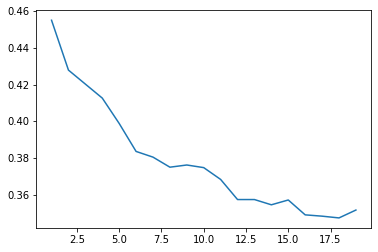

In [ ]:
ks = pd.Series(range(1, 20))
ks.index = range(1, 20)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line()
test_errs.sort_values()

In [4]:
def get_cv_error_mlp_iterations(k):
  # define pipeline
  pipeline = make_pipeline(
      MLPClassifier(max_iter=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


200    0.139307
300    0.160130
100    0.165221
400    0.206194
dtype: float64

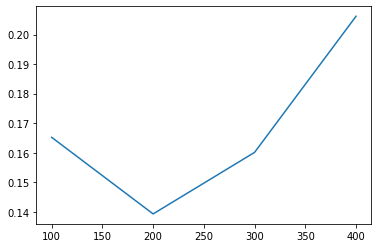

In [5]:
from sklearn.neural_network import MLPClassifier

ks = pd.Series(range(100, 500, 100))
ks.index = range(100, 500, 100)
test_errs = ks.apply(get_cv_error_mlp_iterations)

test_errs.plot.line()
test_errs.sort_values()



In [9]:
def get_cv_error_mlp_hidden_layers(k):
  # define pipeline
  pipeline = make_pipeline(
      MLPClassifier(hidden_layer_sizes=k, max_iters=300)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

In [ ]:
from sklearn.neural_network import MLPClassifier

ks = pd.Series(range(100, 500, 100))
ks.index = range(100, 500, 100)
test_errs = ks.apply(get_cv_error_mlp_hidden_layers)

test_errs.plot.line()
test_errs.sort_values()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by 

In [ ]:

from sklearn.metrics import classification_report,confusion_matrix

predictions = mlp.predict(X_test)
print(classification_report(y_test,predictions))

[[  1 264   0   0]
 [  1 264   0   0]
 [  0 266   0   3]
 [  0 250   0   1]]
              precision    recall  f1-score   support

           1       0.50      0.00      0.01       265
           2       0.25      1.00      0.40       265
           3       0.00      0.00      0.00       269
           4       0.25      0.00      0.01       251

    accuracy                           0.25      1050
   macro avg       0.25      0.25      0.10      1050
weighted avg       0.25      0.25      0.11      1050



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.49      0.53      0.51       265
           2       0.49      0.44      0.46       265
           3       1.00      1.00      1.00       269
           4       1.00      1.00      1.00       251

    accuracy                           0.74      1050
   macro avg       0.74      0.74      0.74      1050
weighted avg       0.74      0.74      0.74      1050

